In [1]:
# Load necessary packages
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
from jax.random import uniform, PRNGKey

# User-defined
from ANN_1DOF import Damped_MLP, Damped_LNN
from helpers import train_test_data, generate_data

#### Generate Training Data

In [2]:
# Generate continuation data
old_train_dataset, old_test_dataset, info = train_test_data(
    save_file='data/data.pkl', 
    split_size=0.20, 
    file_name='contparameters.json', 
    min_force_amp=0.1, 
    max_force_amp=1.0, 
    step=0.1, 
    phase_ratio=0.5, 
    damping=0.05
)



Iter Cont     Iter Corr     Residual      Freq          Energy        Step          Beta          
0             0             1.2826e-01    0.0955        5.0861e-02                                
0             1             4.2430e-03    0.0955        1.9854e-02                                
0             2             9.4199e-07    0.0955        1.9376e-02                                
1             0             8.2709e-07    0.0955        1.9391e-02    -5.000e-03                  
1             1             1.9545e-13    0.0955        1.9392e-02    -5.000e-03    0.0022        
--------------------------------------------------------------------------------------------------
2             0             5.4762e-07    0.0956        1.9423e-02    -1.000e-02                  
2             1             1.2469e-13    0.0956        1.9423e-02    -1.000e-02    0.0039        
--------------------------------------------------------------------------------------------------
3       

In [3]:
info

{'delta': 0.05,
 'alpha': 1.0,
 'beta': 1.0,
 'M': 1.0,
 'K': 1.0,
 'C': 0.05,
 'NL': 1.0,
 'train_n_datapoints': 521040,
 'test_n_datapoints': 132431,
 'qmax': 3.539038022161649,
 'qdmax': 9.197666668716968,
 'qddmax': 41.03203098968057,
 't': 9.23405928306095,
 'fmax': 1.0}

In [4]:
old_train_dataset.keys()

dict_keys(['x', 'dx', 'ddx', 't', 'f'])

In [5]:
old_train_dataset['x'].shape, old_train_dataset['dx'].shape, old_train_dataset['ddx'].shape, old_train_dataset['t'].shape, old_train_dataset['f'].shape

((240, 2171), (240, 2171), (240, 2171), (240, 2171), (240, 2171))

In [6]:
old_train_dataset['x'].flatten(), old_train_dataset['dx'].flatten()

(array([ 0.43669081,  0.43949375,  0.44238266, ..., -0.37201587,
        -0.39564315, -0.41933339]),
 array([ 0.28859455,  0.29299757,  0.29759294, ..., -7.00905451,
        -7.00330051, -6.9968278 ]))

In [7]:
train_x = np.vstack((old_train_dataset['x'].flatten(), old_train_dataset['dx'].flatten())).T
train_f = old_train_dataset['f'].flatten()
train_dx = np.vstack((old_train_dataset['dx'].flatten(), old_train_dataset['ddx'].flatten())).T

test_x = np.vstack((old_test_dataset['x'].flatten(), old_test_dataset['dx'].flatten())).T
test_f = old_test_dataset['f'].flatten()
test_dx = np.vstack((old_test_dataset['dx'].flatten(), old_test_dataset['ddx'].flatten())).T

train_dataset = train_x, train_f, train_dx
test_dataset = test_x, test_f, test_dx

#### LNN Training

In [8]:
settings = {
    'name': 'ANN_LNN_Damped_Test',
    'lag_units': 128,
    'damp_units': 16,
    'layers': 3,
    'input_shape': 2,
    'train_batch_size': 128,
    'test_batch_size': 64,
    'shuffle': True,
    'seed': 0
    }

phy_sys = {
    'M': info['M'],
    'K': info['K'],
    'C': info['C'],
    'NL': info['NL'],
}

lr = 1e-3
optimizer = optax.adam(lr)
a = Damped_LNN(Damped_MLP, optimizer, settings, info, phy_sys)
a.gather()

/home/aax23/PyCont_release/examples/duffing/ANN_1DOF.py:104: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  init_data = jnp.zeros((self.input_shape), dtype=jnp.float64)
/home/aax23/PyCont_release/examples/duffing/ANN_1DOF.py:351: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  qmax = jnp.array([self.info['qmax']], dtype=jnp.float64)
/home/aax23/PyCont_release/examples/duffing/ANN_1DOF.py:352: UserWarning: Explicitly requested dtype <class 'jax

True

In [9]:
# Load previous results, if any
prev_results = a.load_model('results/ANN_Damped_100epochs/model.pkl')

In [10]:
# Start training LNN
results = a.train(train_dataset, test_dataset, results=None, epochs=100, show_every=10)

Epoch: 0 | Train Loss: 1190.03881836 | Best Loss: 18.17270470 | Test Loss: 18.17270470
--------------------------------------------------------------------------------------------------------
Epoch: 10 | Train Loss: 0.00026453 | Best Loss: 0.00032937 | Test Loss: 0.00032937
--------------------------------------------------------------------------------------------------------
Epoch: 20 | Train Loss: 0.00005386 | Best Loss: 0.00010010 | Test Loss: 0.00037070
--------------------------------------------------------------------------------------------------------
Epoch: 30 | Train Loss: 0.00002883 | Best Loss: 0.00000692 | Test Loss: 0.00003279
--------------------------------------------------------------------------------------------------------
Epoch: 40 | Train Loss: 0.00002473 | Best Loss: 0.00000353 | Test Loss: 0.00000353
--------------------------------------------------------------------------------------------------------
Epoch: 50 | Train Loss: 0.00001644 | Best Loss: 0.000003

In [11]:
# Save results
a.save_model(results, 'results/ANN_Damped_100epochs')

('results/ANN_Damped_100epochs/model.pkl',
 'results/ANN_Damped_100epochs/metrics.pkl')

### Examine results

In [12]:
# Plotting the corresponding lagrangian and damping function for each output in the test dataset
pred_acc_damped, pred_energy_damped = a._predict(results)
q, q_d = jnp.split(test_dataset[0], 2, axis=-1)
n = 301
Lnn, Dnn = pred_energy_damped(q, q_d)

/home/aax23/PyCont_release/examples/duffing/ANN_1DOF.py:351: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  qmax = jnp.array([self.info['qmax']], dtype=jnp.float64)
/home/aax23/PyCont_release/examples/duffing/ANN_1DOF.py:352: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  q_dmax = jnp.array([self.info['qdmax']], dtype=jnp.float64)


In [13]:
# Comparing accelerations
F = test_dataset[1].reshape(q.shape[0], -1)
q_dd = pred_acc_damped(test_dataset[0], F)[:, -1]

In [14]:
test_dataset

(array([[ 2.99008792e-03, -5.36796601e-01],
        [ 3.79838571e-03, -5.02474613e-01],
        [ 4.34579389e-03, -4.71888586e-01],
        ...,
        [-2.52359743e+00,  6.99647584e+00],
        [-2.53978044e+00,  6.94382869e+00],
        [-2.55584487e+00,  6.88966203e+00]]),
 array([-0.03139526, -0.03139526, -0.03139526, ...,  0.34227355,
         0.34227355,  0.34227355]),
 array([[-5.36796601e-01, -7.54554437e-03],
        [-5.02474613e-01, -1.00699696e-02],
        [-4.71888586e-01, -1.21467064e-02],
        ...,
        [ 6.99647584e+00,  1.85876884e+01],
        [ 6.94382869e+00,  1.89176773e+01],
        [ 6.88966203e+00,  1.92492907e+01]]))

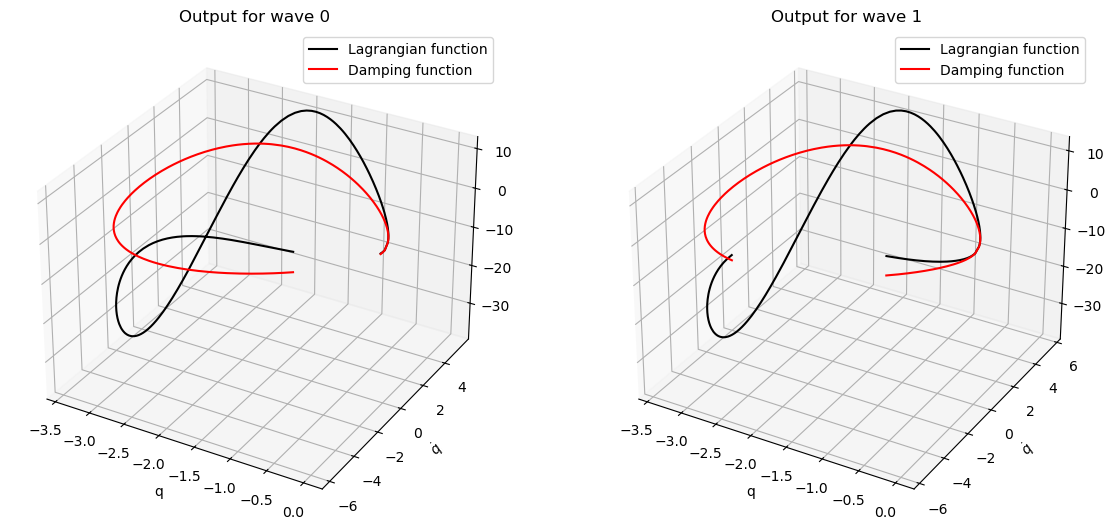

In [15]:
fig = plt.figure(figsize=(14,14))

for i in range(2):
    ax = fig.add_subplot(221 + i, projection='3d')
    ax.plot3D(q.squeeze()[n*i:n*(i+1)], q_d.squeeze()[n*i:n*(i+1)], Lnn.squeeze()[n*i:n*(i+1)], color='black', label= 'Lagrangian function')
    ax.plot3D(q.squeeze()[n*i:n*(i+1)], q_d.squeeze()[n*i:n*(i+1)], Dnn.squeeze()[n*i:n*(i+1)], color='red', label= 'Damping function')
    ax.set_title('Output for wave ' + str(i))
    ax.set_xlabel('q')
    ax.set_ylabel(r'$\dot{q}$')
    plt.legend()

In [16]:
lim1, lim2 = info['qmax'], info['qdmax']

qa, qda = jnp.linspace(-lim1, lim1, 100), jnp.linspace(-lim2, lim2, 100)
qaa, qdaa = jnp.meshgrid(qa, qda)

# Get all energy functions here
L, D = jax.vmap(pred_energy_damped)(qaa.reshape(-1,1,1), qdaa.reshape(-1,1,1))
Lagrange_analy = 0.5*phy_sys['M']*qdaa**2 - 0.5*phy_sys['K']*qaa**2 - 0.25*phy_sys['NL']*qaa**4
Dissipation_analy = 0.5*phy_sys['C']*qdaa**2

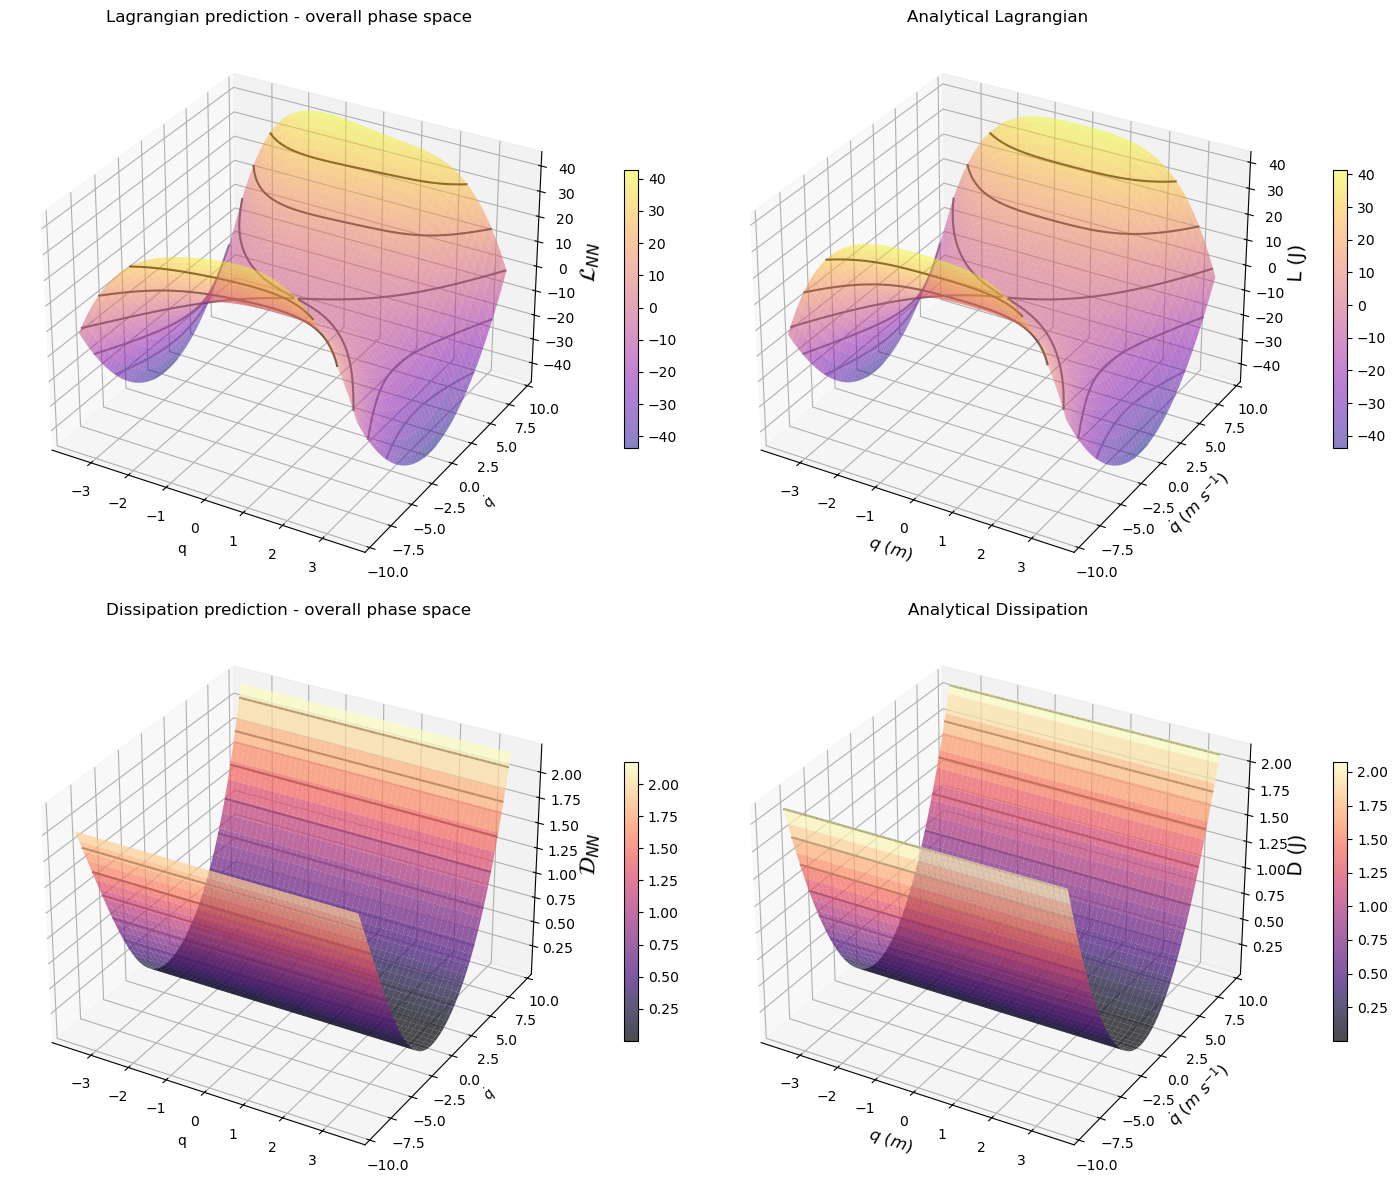

In [17]:
fig = plt.figure(figsize=(15,12), tight_layout=True)

ax = fig.add_subplot(221, projection='3d')
m = ax.plot_surface(qaa, qdaa, L.reshape(qaa.shape), alpha=0.5, cmap='plasma')
ax.contour3D(qaa, qdaa, L.reshape(qaa.shape), cmap='binary')
ax.set_xlabel('q')
ax.set_ylabel(r'$\dot{q}$')
ax.set_zlabel(r'$\mathcal{L}_{NN}$', fontsize=16, labelpad=3)
ax.set_title('Lagrangian prediction - overall phase space')
fig.colorbar(m, ax=ax,shrink=0.5, pad=0.075)

ax = fig.add_subplot(222, projection = '3d')
m = ax.plot_surface(qaa, qdaa, Lagrange_analy.reshape(qaa.shape), alpha=0.5, cmap='plasma')
ax.contour3D(qaa, qdaa, Lagrange_analy.reshape(qaa.shape), cmap='binary')
ax.set_title('Analytical Lagrangian')
ax.set_xlabel(r'$q \ (m)$', fontsize=12)
ax.set_ylabel(r'$\dot{q} \ (m \ s^{-1})$ ', fontsize=12)
ax.set_zlabel(r'L (J)', fontsize=14, labelpad=2)
fig.colorbar(m, ax=ax,shrink=0.5, pad=0.075)

ax = fig.add_subplot(223, projection='3d')
m = ax.plot_surface(qaa, qdaa, D.reshape(qaa.shape), alpha=0.7, cmap='magma')
ax.contour3D(qaa, qdaa, D.reshape(qaa.shape), cmap='binary')
ax.set_xlabel('q')
ax.set_ylabel(r'$\dot{q}$')
ax.set_zlabel(r'$\mathcal{D}_{NN}$', fontsize=16, labelpad=3)
ax.set_title('Dissipation prediction - overall phase space')
fig.colorbar(m, ax=ax,shrink=0.5, pad=0.075)

ax = fig.add_subplot(224, projection = '3d')
m = ax.plot_surface(qaa, qdaa, Dissipation_analy.reshape(qaa.shape), alpha=0.7, cmap='magma')
ax.contour3D(qaa, qdaa, Dissipation_analy.reshape(qaa.shape), cmap='binary')
ax.set_title('Analytical Dissipation')
ax.set_xlabel(r'$q \ (m)$', fontsize=12)
ax.set_ylabel(r'$\dot{q} \ (m \ s^{-1})$ ', fontsize=12)
ax.set_zlabel(r'D (J)', fontsize=14, labelpad=2)
fig.colorbar(m, ax=ax,shrink=0.5, pad=0.075)